In [51]:
%matplotlib notebook

import pandas as pd
import numpy as np
from collections import OrderedDict as od, Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [59]:
# Reading in training data

X = pd.read_csv('X_train.txt', delim_whitespace=True, header=None).values
y = pd.read_csv('y_train.txt', delim_whitespace=True, header=None).values.flatten()
X.shape

(7352, 561)

In [60]:
#Check distribution of classes
classes = np.unique(np.sort(y))
class_counts = Counter()
for y_el in y:
    class_counts[y_el] += 1
class_counts = od(class_counts)

data = [go.Bar(x = list(class_counts.keys()), y = list(class_counts.values()))]
figure = go.Figure(data = data, layout = go.Layout(yaxis = dict(title = 'counts'),
                                                  xaxis = dict(title = 'target classes'),
                                                  title = 'Target Class Distribution'))

plotly.offline.iplot(figure)

In [3]:
# Standardizing data

from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit_transform(X)
# WORKS BETTER WITHOUT STANDARDIZATION

In [4]:
# Creating kernel-based Naive Bayes Classifier

from sklearn.neighbors import KernelDensity
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [6]:
# Do a grid search on sample to determine best hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# sampling data
sample_frac = 1/10.
X_sam, _, y_sam, _ = train_test_split(X, y, stratify = y, train_size = sample_frac,
                                           random_state = 0)

# grid search
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
bandwidths = 10 ** np.linspace(-1, 1.1, 10)
grid = GridSearchCV(KDEClassifier(), od([('kernel', kernels), ('bandwidth', bandwidths)]),
                   n_jobs = 1, verbose = 2) #can't use higher n_jobs because of mp incomp
                                            #issue with our defined class
grid.fit(X_sam, y_sam)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] kernel=gaussian, bandwidth=0.1 ..................................
[CV] ................... kernel=gaussian, bandwidth=0.1, total=   0.2s
[CV] kernel=gaussian, bandwidth=0.1 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] ................... kernel=gaussian, bandwidth=0.1, total=   0.1s
[CV] kernel=gaussian, bandwidth=0.1 ..................................
[CV] ................... kernel=gaussian, bandwidth=0.1, total=   0.1s
[CV] kernel=tophat, bandwidth=0.1 ....................................
[CV] ..................... kernel=tophat, bandwidth=0.1, total=   0.0s
[CV] kernel=tophat, bandwidth=0.1 ....................................
[CV] ..................... kernel=tophat, bandwidth=0.1, total=   0.0s
[CV] kernel=tophat, bandwidth=0.1 ....................................
[CV] ..................... kernel=tophat, bandwidth=0.1, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.1 ..............................
[CV] ............... kernel=epanechnikov, bandwidth=0.1, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.1 ..............................
[CV] ............... kernel=epanechnikov, bandwidth=0.1, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.1 ..............................
[CV] .

[CV] .......... kernel=tophat, bandwidth=0.501187233627, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.501187233627 ...................
[CV] .... kernel=epanechnikov, bandwidth=0.501187233627, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.501187233627 ...................
[CV] .... kernel=epanechnikov, bandwidth=0.501187233627, total=   0.0s
[CV] kernel=epanechnikov, bandwidth=0.501187233627 ...................
[CV] .... kernel=epanechnikov, bandwidth=0.501187233627, total=   0.0s
[CV] kernel=exponential, bandwidth=0.501187233627 ....................
[CV] ..... kernel=exponential, bandwidth=0.501187233627, total=   0.2s
[CV] kernel=exponential, bandwidth=0.501187233627 ....................
[CV] ..... kernel=exponential, bandwidth=0.501187233627, total=   0.1s
[CV] kernel=exponential, bandwidth=0.501187233627 ....................
[CV] ..... kernel=exponential, bandwidth=0.501187233627, total=   0.1s
[CV] kernel=linear, bandwidth=0.501187233627 .........................
[CV] .

[CV] ...... kernel=exponential, bandwidth=2.51188643151, total=   0.1s
[CV] kernel=exponential, bandwidth=2.51188643151 .....................
[CV] ...... kernel=exponential, bandwidth=2.51188643151, total=   0.2s
[CV] kernel=exponential, bandwidth=2.51188643151 .....................
[CV] ...... kernel=exponential, bandwidth=2.51188643151, total=   0.1s
[CV] kernel=linear, bandwidth=2.51188643151 ..........................
[CV] ........... kernel=linear, bandwidth=2.51188643151, total=   0.0s
[CV] kernel=linear, bandwidth=2.51188643151 ..........................
[CV] ........... kernel=linear, bandwidth=2.51188643151, total=   0.0s
[CV] kernel=linear, bandwidth=2.51188643151 ..........................
[CV] ........... kernel=linear, bandwidth=2.51188643151, total=   0.0s
[CV] kernel=cosine, bandwidth=2.51188643151 ..........................
[CV] ........... kernel=cosine, bandwidth=2.51188643151, total=   0.1s
[CV] kernel=cosine, bandwidth=2.51188643151 ..........................
[CV] .

[CV] ........... kernel=linear, bandwidth=12.5892541179, total=   0.1s
[CV] kernel=linear, bandwidth=12.5892541179 ..........................
[CV] ........... kernel=linear, bandwidth=12.5892541179, total=   0.1s
[CV] kernel=cosine, bandwidth=12.5892541179 ..........................
[CV] ........... kernel=cosine, bandwidth=12.5892541179, total=   0.2s
[CV] kernel=cosine, bandwidth=12.5892541179 ..........................
[CV] ........... kernel=cosine, bandwidth=12.5892541179, total=   0.1s
[CV] kernel=cosine, bandwidth=12.5892541179 ..........................
[CV] ........... kernel=cosine, bandwidth=12.5892541179, total=   0.1s


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.7min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KDEClassifier(bandwidth=1.0, kernel='gaussian'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=OrderedDict([('kernel', ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']), ('bandwidth', array([  0.1    ,   0.17113,   0.29286,   0.50119,   0.8577 ,   1.4678 ,
         2.51189,   4.29866,   7.35642,  12.58925]))]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [7]:
# plotting accurac vs hyperparameters

cv_results = grid.cv_results_

scores_shaped = np.empty(shape = (len(bandwidths), len(kernels)))
for dic_ix, dic in enumerate(cv_results['params']):
    ker_ix = kernels.index(dic['kernel'])
    band_ix = np.argmin(np.abs(bandwidths - dic['bandwidth']))
    scores_shaped[band_ix, ker_ix] = cv_results['mean_test_score'][dic_ix]

trace = go.Heatmap(x = kernels,
                   y = list(np.vectorize(lambda b: 'bw ' + '{0:.2f}'.format(b))
                            (bandwidths)),
                   z = scores_shaped)
data=[trace]
figure = go.Figure(data = data, layout = go.Layout(title = 'Accuracy (3-fold cross-validated)'))
plotly.offline.iplot(figure)

In [8]:
print('Best parameters =', grid.best_params_)

Best parameters = {'kernel': 'gaussian', 'bandwidth': 0.85769589859089412}


In [12]:
# Zooming in on good parameter region with all data

# grid search
kernels = ['gaussian']
bandwidths = np.linspace(.5, 1.6, 30)
grid = GridSearchCV(KDEClassifier(), od([('kernel', kernels), ('bandwidth', bandwidths)]),
                   n_jobs = 1, verbose = 2) #can't use higher n_jobs because of mp incomp
                                            #issue with our defined class
grid.fit(X, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] kernel=gaussian, bandwidth=0.5 ..................................
[CV] ................... kernel=gaussian, bandwidth=0.5, total=  26.8s
[CV] kernel=gaussian, bandwidth=0.5 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] ................... kernel=gaussian, bandwidth=0.5, total=  26.0s
[CV] kernel=gaussian, bandwidth=0.5 ..................................
[CV] ................... kernel=gaussian, bandwidth=0.5, total=  27.4s
[CV] kernel=gaussian, bandwidth=0.537931034483 .......................
[CV] ........ kernel=gaussian, bandwidth=0.537931034483, total=  26.3s
[CV] kernel=gaussian, bandwidth=0.537931034483 .......................
[CV] ........ kernel=gaussian, bandwidth=0.537931034483, total=  25.9s
[CV] kernel=gaussian, bandwidth=0.537931034483 .......................
[CV] ........ kernel=gaussian, bandwidth=0.537931034483, total=  26.3s
[CV] kernel=gaussian, bandwidth=0.575862068966 .......................
[CV] ........ kernel=gaussian, bandwidth=0.575862068966, total=  26.7s
[CV] kernel=gaussian, bandwidth=0.575862068966 .......................
[CV] ........ kernel=gaussian, bandwidth=0.575862068966, total=  26.2s
[CV] kernel=gaussian, bandwidth=0.575862068966 .......................
[CV] .

[CV] ......... kernel=gaussian, bandwidth=1.22068965517, total=  29.1s
[CV] kernel=gaussian, bandwidth=1.25862068966 ........................
[CV] ......... kernel=gaussian, bandwidth=1.25862068966, total=  30.1s
[CV] kernel=gaussian, bandwidth=1.25862068966 ........................
[CV] ......... kernel=gaussian, bandwidth=1.25862068966, total=  29.9s
[CV] kernel=gaussian, bandwidth=1.25862068966 ........................
[CV] ......... kernel=gaussian, bandwidth=1.25862068966, total=  30.2s
[CV] kernel=gaussian, bandwidth=1.29655172414 ........................
[CV] ......... kernel=gaussian, bandwidth=1.29655172414, total=  31.1s
[CV] kernel=gaussian, bandwidth=1.29655172414 ........................
[CV] ......... kernel=gaussian, bandwidth=1.29655172414, total=  29.4s
[CV] kernel=gaussian, bandwidth=1.29655172414 ........................
[CV] ......... kernel=gaussian, bandwidth=1.29655172414, total=  28.9s
[CV] kernel=gaussian, bandwidth=1.33448275862 ........................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 240.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KDEClassifier(bandwidth=1.0, kernel='gaussian'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=OrderedDict([('kernel', ['gaussian']), ('bandwidth', array([ 0.5    ,  0.53793,  0.57586,  0.61379,  0.65172,  0.68966,
        0.72759,  0.76552,  0.80345,  0.84138,  0.87931,  0.91724,
        0.95517,  0.9931 ,  1.03103,  1.06897,  1.1069 ,  1.14483,
        1.18276,  1.22069,  1.25862,  1.29655,  1.33448,  1.37241,
        1.41034,  1.44828,  1.48621,  1.52414,  1.56207,  1.6    ]))]),
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [13]:
print('Best parameters =', grid.best_params_)

Best parameters = {'kernel': 'gaussian', 'bandwidth': 0.80344827586206902}


In [14]:
grid.cv_results_

{'mean_fit_time': array([ 0.2232182 ,  0.16982834,  0.17283861,  0.17516692,  0.17217048,
         0.17050298,  0.17050997,  0.17316532,  0.17350515,  0.17351349,
         0.17184289,  0.17184329,  0.18284814,  0.1741728 ,  0.17284544,
         0.17484649,  0.19485911,  0.23008355,  0.21470928,  0.17618132,
         0.17351309,  0.17617496,  0.18085122,  0.17284481,  0.18604906,
         0.17917625,  0.17251094,  0.1725107 ,  0.19152927,  0.1745131 ]),
 'mean_score_time': array([ 26.61517239,  26.09104649,  26.42463819,  26.65954876,
         26.93747163,  27.19419924,  27.42672356,  27.56306696,
         27.82859294,  27.90100781,  28.02651262,  28.80546133,
         31.47179063,  28.55202047,  28.37777313,  28.97809752,
         29.92529321,  35.73036536,  31.92600973,  29.03377827,
         29.9884011 ,  29.74170399,  29.02994831,  29.16147963,
         29.54194339,  29.56372499,  30.45256448,  30.13385638,
         29.49398009,  29.90678477]),
 'mean_test_score': array([ 0.73585419

<IPython.core.display.Javascript object>


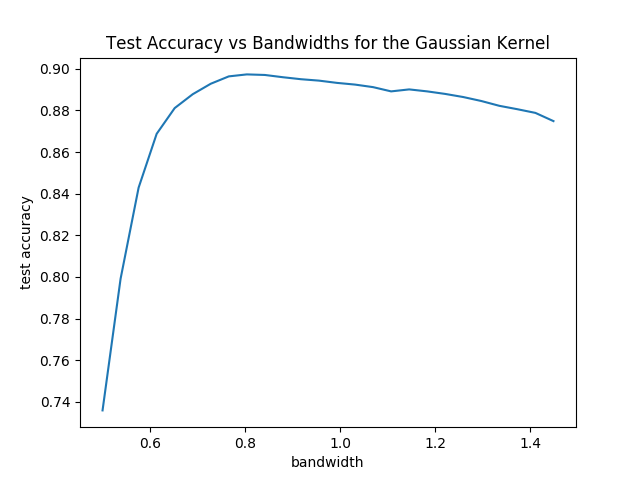

In [55]:
# plotting accuracy vs bandwidth
ax = plt.subplots()[1]
ax.set_xlabel('bandwidth'); ax.set_ylabel('test accuracy')
ax.set_title('Test Accuracy vs Bandwidths for the Gaussian Kernel')
ax.plot(bandwidths[:-4], grid.cv_results_['mean_test_score'][:-4])

In [61]:
# training the best classifier on the full training set 
# using it to predict outputs for the test set
'''
model_best = grid.best_estimator_
model_best.fit(X, y)
'''

model_best = KDEClassifier(kernel = grid.best_params_['kernel'],
                          bandwidth = grid.best_params_['bandwidth'])
model_best.fit(X, y)

X_test = pd.read_csv('X_test.txt', delim_whitespace=True, header=None)
y_pred = model_best.predict(X_test)

In [62]:
#saving predicted outputs
y_pred_df = pd.DataFrame(data = np.reshape(y_pred, newshape = (-1, 1)))
y_pred_df.to_csv('y_pred.txt', header = False, index = False)

In [63]:
# predictions class distribution

classes = np.unique(np.sort(y_pred))
class_counts = Counter()
for y_el in y_pred:
    class_counts[y_el] += 1
class_counts = od(class_counts)

data = [go.Bar(x = list(class_counts.keys()), y = list(class_counts.values()))]
figure = go.Figure(data = data, layout = go.Layout(yaxis = dict(title = 'counts'),
                                                  xaxis = dict(title = 'target classes'),
                                                  title = 'Target Class Distribution'))

plotly.offline.iplot(figure)